In [1]:
# import packages
import numpy as np
import pandas as pd
import nltk
from bertopic import BERTopic
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import umap as UMAP

c:\Users\UPPL - 01\Downloads\Anaconda-coding\envs\bert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import dataset
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")
df.head()

,outlet,article_text,content_sentence,content_words
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"['tij', 'iginla', 'shy', 'away', 'famous', 'la..."
1,CBC.ca,This week on The Sunday Magazine with host Piy...,week sunday magazine host piya chattopadhyay s...,"['week', 'sunday', 'magazine', 'host', 'piya',..."
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp use chatgpt share inco...,"['ontario', 'conservative', 'mp', 'use', 'chat..."
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"['come', 'study', 'sport', 'man', 'body', 'lon..."
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap th season quirk quark got another edition...,"['wrap', 'th', 'season', 'quirk', 'quark', 'go..."


In [3]:
# additional pre-processing
custom_stopwords = set([
    "could", "should", "would", "may", "might", "said", "year", "just", "many", "even", 
    "still", "back",  "day", "week", "month", "use", "give", "take", "since", "much", 
    "got", "whether", "look", "always", "let", "yet", "asked", "across", "cooky", "cookie",
    "cookies", "setting", "settings", "site", "sites", "website", "websites", "web", "page",
    "browser", "privacy", "advertisement", "advertisements", "ad", "ads", ])

# Uncomment this line when running the code for the first time after importing csv
df['content_words'] = df['content_words'].apply(eval)

df['content_words'] = df['content_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

df["content_sentence"] = df["content_words"].apply(lambda x: " ".join(x))

# drop all null values
# df = df["headline_sentence"].dropna()

df.head()

,outlet,article_text,content_sentence,content_words
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i..."
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ..."
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in..."
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider..."
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap th season quirk quark another edition lis...,"[wrap, th, season, quirk, quark, another, edit..."


In [9]:
len(df)

40945

In [11]:
# initialize BERTopic
topic_model_i = BERTopic(language="english", calculate_probabilities=True, nr_topics="auto", min_topic_size=50)

# fit BERTopic
topics, probs = topic_model_i.fit_transform(df['content_sentence'])

# Print the top topics
print(topic_model_i.get_topic_info())

   Topic  Count                          Name  \
0     -1  14449  -1_trump_biden_president_one   
1      0  25226   0_trump_president_one_biden   
2      1   1270   1_associated_usa_real_clear   

                                      Representation  \
0  [trump, biden, president, one, harris, new, pe...   
1  [trump, president, one, biden, also, time, new...   
2         [associated, usa, real, clear, , , , , , ]   

                                 Representative_Docs  
0  [washington sitting vice president office also...  
1  [house speaker mike johnson sunday president j...  
2               [associated, associated, associated]  


In [7]:
topic_model_i.save("bertopic_model_content")

2025-03-29 21:25:12,489 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


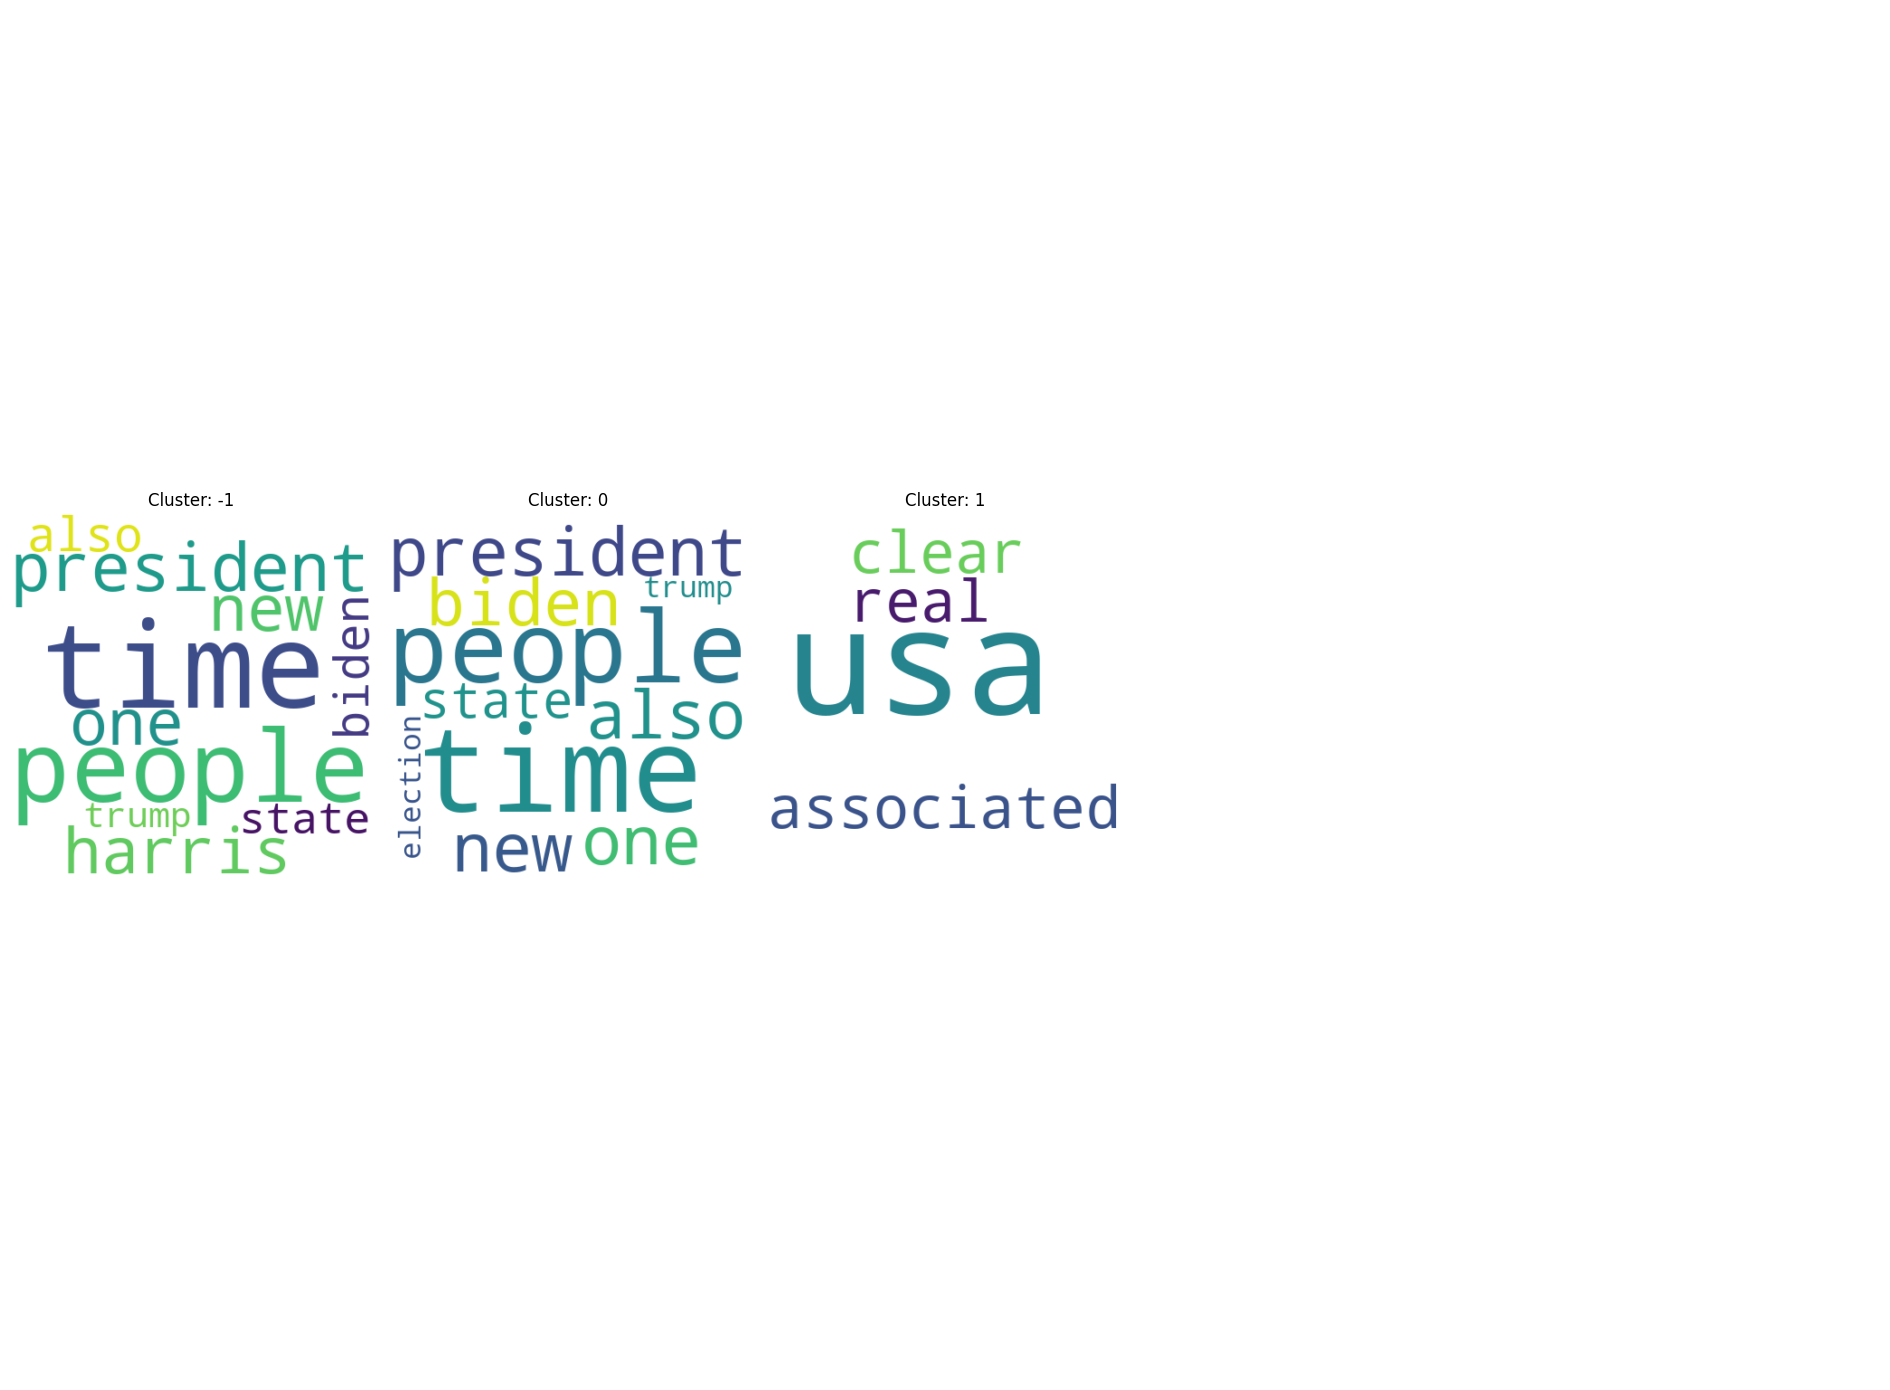

In [12]:
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud

top_n = 20
top_words = {}

# Retrieve the topic-word mappings from the BERTopic model
topic_word_mappings = topic_model_i.get_topics()

for topic_id, topic_words in topic_word_mappings.items():
    # Get the top N words for each topic (sorted by importance)
    top_words[topic_id] = [word for word, _ in topic_words[:top_n]]

num_topics = len(top_words)
num_rows = math.ceil(num_topics / 5)  # 5 columns per row
num_cols = 5

# Create the subplots grid dynamically based on the number of topics
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(19, 14))
axes = axes.flatten()  # Flatten for easier indexing

num_clusters = len(top_words)
if num_clusters == 1:  # If only 1 cluster, make `axes` iterable
    axes = [axes]

for i, (cluster_label, words) in enumerate(top_words.items()):
    # Create word frequency dictionary
    word_freqs = {word: words.count(word) for word in set(words)}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freqs)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Cluster: {cluster_label}", fontsize=12)

# Remove unused axes 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

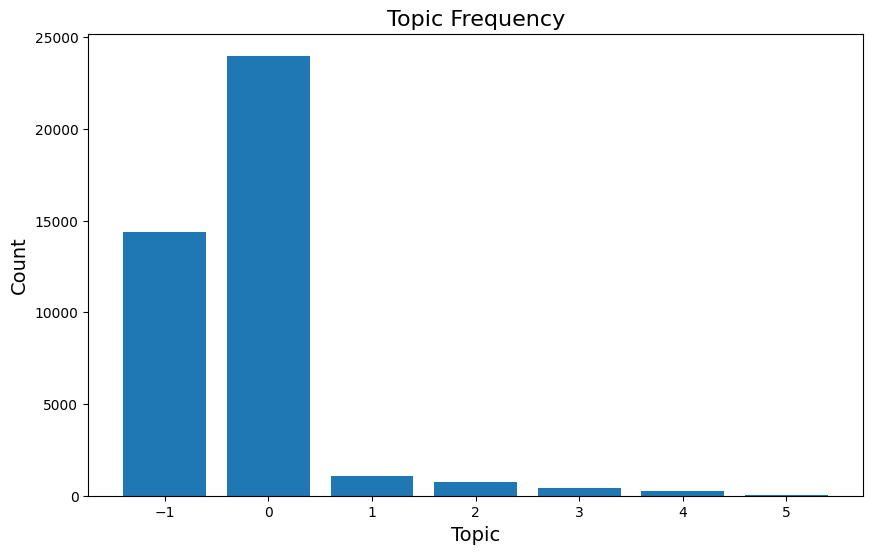

In [10]:
from collections import Counter

# topic_model = BERTopic.load("bertopic_model_content")

# Count the frequency of each topic
topics_df = topic_model_i.get_topic_info()
# plot a bar chart of the topic frequency
plt.figure(figsize=(10, 6)) 
plt.bar(topics_df["Topic"], topics_df["Count"])
plt.xlabel("Topic", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Topic Frequency", fontsize=16)
plt.show()



In [ ]:
from sklearn.metrics import silhouette_score

# Get the reduced-dimensional embeddings from the BERTopic model
embeddings = topic_model.transform(df['content_sentence'])[1]

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(embeddings, topics_df["Topic"])
print(f"Silhouette Score: {silhouette_avg}")